### the Fast Gradient Sign Attack (FGSM) 
* the first and most popular attack methods    
* a white-box attack with the goal of misclassification 


#### Practice 
* to attack an ```MNIST``` classifier with the FGSM

In [16]:
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms 

### input 

In [17]:
epsilons = [0, .05, .1, .15, .2, .25, .3]  # perturbation level 
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [18]:
device

device(type='cuda')

### Model define 

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x 

In [20]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [21]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./dataset', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [22]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

***

### FGSM Attack 

* Collect the element-wise sign of the data gradient
* Create the perturbed image by adjusting each pixel of the input image
* Adding clipping to maintain [0,1] range
* Return the perturbed image

In [23]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

### Testing Function 


In [24]:
def test_fgsm( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    criterion = nn.CrossEntropyLoss()

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
        
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run Attack 

In [25]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in tqdm(epsilons):
    acc, ex = test_fgsm(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

 14%|█▍        | 1/7 [00:40<04:03, 40.51s/it]

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981


 29%|██▊       | 2/7 [01:19<03:20, 40.17s/it]

Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426


 43%|████▎     | 3/7 [01:59<02:39, 39.92s/it]

Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851


 57%|█████▋    | 4/7 [02:38<01:59, 39.84s/it]

Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826


 71%|███████▏  | 5/7 [03:18<01:19, 39.63s/it]

Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301


 86%|████████▌ | 6/7 [03:57<00:39, 39.45s/it]

Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082


100%|██████████| 7/7 [04:36<00:00, 39.44s/it]

Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


### Results 
* Accuracy vs. Epsilon 
* you can see the accuracy decreases according to the increasing epsilon

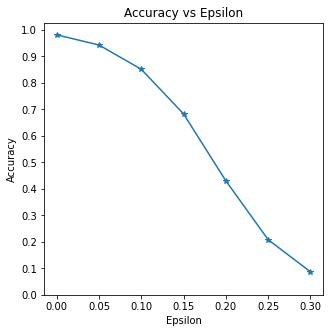

In [26]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples 
* Plot several examples of adversarial samples at each epsilon

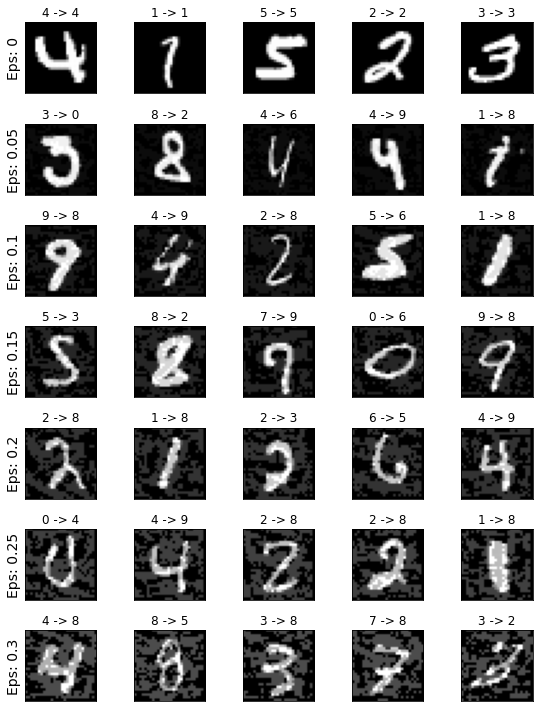

In [27]:
count = 0
plt.figure(figsize=(8,10))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        plt.subplot(len(epsilons),len(examples[0]),count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

***

### Learnable delta attack

In [8]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485], std=[0.229])

In [9]:
# PGD attack code
def learnable_delta_attack(image, target ,epsilon,  model):
    
    # init. delta(=perturbation)
    delta = torch.zeros_like(image, requires_grad=True) # MNIST 28x28
    opt = optim.Adam([delta], lr=5e-3)
    
    for t in range(30):
        perturbed_image = norm(image + delta)
        pred = model(perturbed_image)
        
        loss = -nn.CrossEntropyLoss()(pred, target)
    
#        if t%5 == 0: 
#            print(t, loss.item())
            
        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)
    return perturbed_image

In [12]:
def test_delta( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    

    # Loop over all examples in test set
    for data, target in test_loader:
        
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        output_true = model(data)
        init_pred = output_true.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        
        # Forward pass the adversarial example through the model        
        perturbed_data = learnable_delta_attack(data, target, epsilon,  model)    
        output = model(perturbed_data)  
        
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue      
            
            
            
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run attack

In [13]:
accuracies = []
examples = []

epsilons = [0, .05, .1, .15, .2, .25, .3]  # perturbation level 


# Run test for each epsilon
for eps in tqdm(epsilons):

    acc, ex = test_delta(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

  3%|▎         | 306/10000 [00:34<18:37,  8.68it/s]


  6%|▌         | 603/10000 [01:09<17:49,  8.79it/s]


  9%|▉         | 899/10000 [01:43<17:03,  8.89it/s]


 12%|█▏        | 1196/10000 [02:17<16:51,  8.71it/s]


 15%|█▍        | 1492/10000 [02:51<16:25,  8.63it/s]


 18%|█▊        | 1785/10000 [03:25<15:39,  8.74it/s]


 21%|██        | 2080/10000 [03:59<14:35,  9.05it/s]


 24%|██▎       | 2374/10000 [04:32<14:47,  8.59it/s]


 27%|██▋       | 2671/10000 [05:07<14:08,  8.64it/s]


 30%|██▉       | 2970/10000 [05:41<13:44,  8.52it/s]


 33%|███▎      | 3264/10000 [06:14<12:57,  8.66it/s]


 36%|███▌      | 3557/10000 [06:48<11:47,  9.11it/s]


 38%|███▊      | 3850/10000 [07:22<11:47,  8.69it/s]


 41%|████▏     | 4148/10000 [07:56<10:39,  9.15it/s]


 44%|████▍     | 4444/10000 [08:30<10:24,  8.90it/s]


 47%|████▋     | 4738/10000 [09:04<09:41,  9.05it/s]


 50%|█████     | 5039/10000 [09:38<09:10,  9.02it/s]


 53%|█████▎    | 5343/10000 [10:13<08:38,  8.97it/s]


 56%|█████▋    | 5639/10000 [10:47<08:24,  8.64it/s]


 59%|█████▉    | 5932/10000 [11:20<07:36,  8.91it/s]


 62%|██████▏   | 6227/10000 [11:54<07:15,  8.66it/s]


 65%|██████▌   | 6526/10000 [12:29<06:41,  8.66it/s]


 68%|██████▊   | 6821/10000 [13:03<06:07,  8.65it/s]


 71%|███████   | 7119/10000 [13:37<05:32,  8.67it/s]


 74%|███████▍  | 7416/10000 [14:11<04:49,  8.93it/s]


 77%|███████▋  | 7713/10000 [14:45<04:10,  9.14it/s]


 80%|████████  | 8013/10000 [15:20<03:42,  8.94it/s]


 83%|████████▎ | 8308/10000 [15:54<03:11,  8.82it/s]


 86%|████████▌ | 8604/10000 [16:28<02:37,  8.85it/s]


 89%|████████▉ | 8898/10000 [17:02<02:07,  8.62it/s]


 92%|█████████▏| 9198/10000 [17:36<01:30,  8.89it/s]


 95%|█████████▍| 9495/10000 [18:10<00:57,  8.85it/s]


 98%|█████████▊| 9798/10000 [18:44<00:22,  8.79it/s]


  0%|          | 1/10000 [00:00<18:51,  8.84it/s]

Epsilon: 0	Test Accuracy = 9699 / 10000 = 0.9699



  3%|▎         | 309/10000 [00:35<18:45,  8.61it/s]


  6%|▌         | 612/10000 [01:09<17:14,  9.07it/s]


  9%|▉         | 915/10000 [01:44<16:29,  9.18it/s]


 12%|█▏        | 1212/10000 [02:18<16:31,  8.86it/s]


 15%|█▌        | 1509/10000 [02:52<15:45,  8.98it/s]


 18%|█▊        | 1805/10000 [03:26<15:54,  8.58it/s]


 21%|██        | 2103/10000 [04:00<14:38,  8.99it/s]


 24%|██▍       | 2399/10000 [04:34<14:35,  8.68it/s]


 27%|██▋       | 2696/10000 [05:08<13:47,  8.82it/s]


 30%|██▉       | 2994/10000 [05:42<12:53,  9.05it/s]


 33%|███▎      | 3297/10000 [06:17<12:14,  9.13it/s]


 36%|███▌      | 3600/10000 [06:51<12:26,  8.58it/s]


 39%|███▉      | 3911/10000 [07:26<11:22,  8.93it/s]


 42%|████▏     | 4207/10000 [08:00<11:12,  8.62it/s]


 45%|████▌     | 4515/10000 [08:35<10:28,  8.73it/s]


 48%|████▊     | 4815/10000 [09:09<09:53,  8.73it/s]


 51%|█████     | 5116/10000 [09:43<09:18,  8.75it/s]


 54%|█████▍    | 5416/10000 [10:17<08:33,  8.93it/s]


 57%|█████▋    | 5726/10000 [10:52<08:08,  8.75it/s]


 60%|██████    | 6027/10000 [11:27<07:28,  8.86it/s]


 63%|██████▎   | 6325/10000 [12:01<06:53,  8.89it/s]


 66%|██████▋   | 6629/10000 [12:35<06:09,  9.12it/s]


 69%|██████▉   | 6932/10000 [13:10<05:43,  8.93it/s]


 72%|███████▏  | 7241/10000 [13:45<05:13,  8.80it/s]


 75%|███████▌  | 7549/10000 [14:20<04:40,  8.74it/s]


 79%|███████▊  | 7853/10000 [14:54<04:05,  8.74it/s]


 82%|████████▏ | 8156/10000 [15:28<03:23,  9.05it/s]


 85%|████████▍ | 8458/10000 [16:03<02:44,  9.39it/s]


 88%|████████▊ | 8768/10000 [16:38<02:15,  9.10it/s]


 91%|█████████ | 9074/10000 [17:12<01:38,  9.38it/s]


 94%|█████████▍| 9377/10000 [17:47<01:07,  9.21it/s]


 97%|█████████▋| 9680/10000 [18:21<00:36,  8.74it/s]


100%|█████████▉| 9981/10000 [18:55<00:02,  9.11it/s]


  0%|          | 1/10000 [00:00<18:39,  8.93it/s]

Epsilon: 0.05	Test Accuracy = 7949 / 10000 = 0.7949



  3%|▎         | 309/10000 [00:35<18:39,  8.66it/s]


  6%|▌         | 620/10000 [01:10<17:00,  9.19it/s]


  9%|▉         | 931/10000 [01:45<16:20,  9.25it/s]


 12%|█▏        | 1235/10000 [02:19<16:15,  8.99it/s]


 15%|█▌        | 1547/10000 [02:55<16:16,  8.66it/s]


 19%|█▊        | 1854/10000 [03:29<15:07,  8.98it/s]


 22%|██▏       | 2154/10000 [04:04<15:07,  8.65it/s]


 25%|██▍       | 2454/10000 [04:38<14:06,  8.92it/s]


 28%|██▊       | 2760/10000 [05:12<12:58,  9.30it/s]


 31%|███       | 3063/10000 [05:47<12:20,  9.37it/s]


 34%|███▎      | 3365/10000 [06:21<12:51,  8.60it/s]


 37%|███▋      | 3674/10000 [06:56<11:57,  8.81it/s]


 40%|███▉      | 3981/10000 [07:30<11:03,  9.08it/s]


 43%|████▎     | 4291/10000 [08:05<10:48,  8.80it/s]


 46%|████▌     | 4591/10000 [08:39<10:05,  8.93it/s]


 49%|████▉     | 4903/10000 [09:14<08:50,  9.60it/s]


 52%|█████▏    | 5210/10000 [09:49<08:53,  8.98it/s]


 55%|█████▌    | 5518/10000 [10:24<08:38,  8.65it/s]


 58%|█████▊    | 5825/10000 [10:58<07:49,  8.90it/s]


 61%|██████▏   | 6132/10000 [11:33<07:22,  8.73it/s]


 64%|██████▍   | 6436/10000 [12:07<06:39,  8.91it/s]


 67%|██████▋   | 6747/10000 [12:42<06:02,  8.97it/s]


 71%|███████   | 7054/10000 [13:17<05:29,  8.94it/s]


 74%|███████▎  | 7361/10000 [13:52<04:59,  8.83it/s]


 77%|███████▋  | 7676/10000 [14:27<04:26,  8.73it/s]


 80%|███████▉  | 7981/10000 [15:01<03:43,  9.03it/s]


 83%|████████▎ | 8286/10000 [15:36<03:17,  8.69it/s]


 86%|████████▌ | 8593/10000 [16:10<02:35,  9.07it/s]


 89%|████████▉ | 8904/10000 [16:45<02:04,  8.79it/s]


 92%|█████████▏| 9215/10000 [17:20<01:28,  8.83it/s]


 95%|█████████▌| 9524/10000 [17:55<00:54,  8.80it/s]


 98%|█████████▊| 9824/10000 [18:30<00:19,  8.94it/s]


  0%|          | 1/10000 [00:00<18:59,  8.78it/s]

Epsilon: 0.1	Test Accuracy = 3484 / 10000 = 0.3484



  3%|▎         | 313/10000 [00:35<16:44,  9.64it/s]


  6%|▋         | 628/10000 [01:10<16:56,  9.22it/s]


  9%|▉         | 948/10000 [01:46<17:06,  8.81it/s]


 13%|█▎        | 1260/10000 [02:21<16:31,  8.81it/s]


 16%|█▌        | 1573/10000 [02:56<15:23,  9.12it/s]


 19%|█▉        | 1892/10000 [03:32<14:51,  9.10it/s]


 22%|██▏       | 2203/10000 [04:06<14:31,  8.95it/s]


 25%|██▌       | 2513/10000 [04:41<14:23,  8.67it/s]


 28%|██▊       | 2827/10000 [05:16<13:12,  9.05it/s]


 31%|███▏      | 3140/10000 [05:52<13:17,  8.60it/s]


 35%|███▍      | 3454/10000 [06:27<12:33,  8.69it/s]


 38%|███▊      | 3757/10000 [07:01<11:55,  8.73it/s]


 41%|████      | 4071/10000 [07:36<11:09,  8.86it/s]


 44%|████▍     | 4381/10000 [08:11<10:34,  8.86it/s]


 47%|████▋     | 4690/10000 [08:46<09:51,  8.97it/s]


 50%|█████     | 5004/10000 [09:21<09:20,  8.92it/s]


 53%|█████▎    | 5312/10000 [09:56<08:41,  8.98it/s]


 56%|█████▌    | 5618/10000 [10:30<07:53,  9.25it/s]


 59%|█████▉    | 5926/10000 [11:05<07:19,  9.27it/s]


 62%|██████▏   | 6238/10000 [11:40<06:51,  9.13it/s]


 66%|██████▌   | 6552/10000 [12:15<06:31,  8.81it/s]


 69%|██████▊   | 6873/10000 [12:51<05:36,  9.30it/s]


 72%|███████▏  | 7183/10000 [13:26<05:09,  9.09it/s]


 75%|███████▌  | 7504/10000 [14:01<04:45,  8.73it/s]


 78%|███████▊  | 7812/10000 [14:36<04:04,  8.97it/s]


 81%|████████▏ | 8128/10000 [15:11<03:33,  8.79it/s]


 84%|████████▍ | 8446/10000 [15:47<02:58,  8.73it/s]


 88%|████████▊ | 8761/10000 [16:22<02:12,  9.34it/s]


 91%|█████████ | 9085/10000 [16:58<01:41,  9.06it/s]


 94%|█████████▍| 9402/10000 [17:33<01:06,  9.00it/s]


 97%|█████████▋| 9723/10000 [18:09<00:29,  9.32it/s]


  0%|          | 1/10000 [00:00<17:20,  9.61it/s]

Epsilon: 0.15	Test Accuracy = 1917 / 10000 = 0.1917



  3%|▎         | 323/10000 [00:36<18:06,  8.90it/s]


  6%|▋         | 635/10000 [01:11<17:39,  8.84it/s]


 10%|▉         | 955/10000 [01:46<17:00,  8.86it/s]


 13%|█▎        | 1277/10000 [02:22<16:16,  8.94it/s]


 16%|█▌        | 1591/10000 [02:57<15:56,  8.79it/s]


 19%|█▉        | 1915/10000 [03:33<14:53,  9.05it/s]


 22%|██▏       | 2235/10000 [04:08<14:17,  9.05it/s]


 26%|██▌       | 2556/10000 [04:44<13:38,  9.09it/s]


 29%|██▉       | 2879/10000 [05:20<12:54,  9.20it/s]


 32%|███▏      | 3199/10000 [05:56<12:42,  8.91it/s]


 35%|███▌      | 3513/10000 [06:31<11:59,  9.02it/s]


 38%|███▊      | 3828/10000 [07:06<11:51,  8.68it/s]


 41%|████▏     | 4139/10000 [07:41<10:57,  8.92it/s]


 44%|████▍     | 4450/10000 [08:15<10:24,  8.89it/s]


 48%|████▊     | 4770/10000 [08:51<09:38,  9.04it/s]


 51%|█████     | 5093/10000 [09:27<08:55,  9.16it/s]


 54%|█████▍    | 5410/10000 [10:02<08:34,  8.91it/s]


 57%|█████▋    | 5734/10000 [10:38<07:40,  9.26it/s]


 61%|██████    | 6070/10000 [11:15<07:30,  8.73it/s]


 64%|██████▍   | 6388/10000 [11:50<06:33,  9.18it/s]


 67%|██████▋   | 6710/10000 [12:26<06:01,  9.11it/s]


 70%|███████   | 7026/10000 [13:01<05:39,  8.75it/s]


 73%|███████▎  | 7348/10000 [13:37<04:53,  9.04it/s]


 77%|███████▋  | 7659/10000 [14:11<04:22,  8.91it/s]


 80%|███████▉  | 7972/10000 [14:46<03:43,  9.06it/s]


 83%|████████▎ | 8294/10000 [15:22<03:12,  8.85it/s]


 86%|████████▌ | 8611/10000 [15:57<02:29,  9.27it/s]


 89%|████████▉ | 8926/10000 [16:32<02:01,  8.82it/s]


 93%|█████████▎| 9254/10000 [17:08<01:21,  9.20it/s]


 96%|█████████▌| 9579/10000 [17:44<00:44,  9.56it/s]


 99%|█████████▉| 9904/10000 [18:20<00:10,  9.39it/s]


  0%|          | 1/10000 [00:00<18:54,  8.81it/s]

Epsilon: 0.2	Test Accuracy = 1916 / 10000 = 0.1916



  3%|▎         | 322/10000 [00:35<18:05,  8.91it/s]


  6%|▋         | 642/10000 [01:11<16:57,  9.19it/s]


 10%|▉         | 972/10000 [01:47<16:26,  9.15it/s]


 13%|█▎        | 1287/10000 [02:22<16:26,  8.84it/s]


 16%|█▌        | 1602/10000 [02:57<15:55,  8.79it/s]


 19%|█▉        | 1912/10000 [03:32<15:13,  8.86it/s]


 22%|██▏       | 2237/10000 [04:08<14:35,  8.86it/s]


 25%|██▌       | 2549/10000 [04:43<13:53,  8.94it/s]


 29%|██▊       | 2856/10000 [05:17<13:15,  8.98it/s]


 32%|███▏      | 3172/10000 [05:52<12:45,  8.92it/s]


 35%|███▍      | 3491/10000 [06:27<12:13,  8.87it/s]


 38%|███▊      | 3810/10000 [07:03<11:11,  9.22it/s]


 41%|████▏     | 4132/10000 [07:38<10:58,  8.91it/s]


 45%|████▍     | 4451/10000 [08:14<10:28,  8.83it/s]


 48%|████▊     | 4759/10000 [08:48<09:40,  9.03it/s]


 51%|█████     | 5086/10000 [09:25<08:46,  9.34it/s]


 54%|█████▍    | 5405/10000 [10:00<08:39,  8.85it/s]


 57%|█████▋    | 5716/10000 [10:35<07:52,  9.07it/s]


 60%|██████    | 6046/10000 [11:11<07:12,  9.14it/s]


 64%|██████▎   | 6374/10000 [11:47<06:52,  8.78it/s]


 67%|██████▋   | 6690/10000 [12:22<06:17,  8.77it/s]


 70%|███████   | 7008/10000 [12:57<05:38,  8.84it/s]


 73%|███████▎  | 7320/10000 [13:32<05:04,  8.80it/s]


 76%|███████▋  | 7633/10000 [14:07<04:27,  8.86it/s]


 80%|███████▉  | 7950/10000 [14:42<03:46,  9.03it/s]


 83%|████████▎ | 8269/10000 [15:17<03:15,  8.83it/s]


 86%|████████▌ | 8581/10000 [15:52<02:40,  8.83it/s]


 89%|████████▉ | 8893/10000 [16:27<02:02,  9.04it/s]


 92%|█████████▏| 9205/10000 [17:01<01:26,  9.17it/s]


 95%|█████████▌| 9522/10000 [17:37<00:50,  9.51it/s]


 98%|█████████▊| 9843/10000 [18:12<00:18,  8.63it/s]


  0%|          | 1/10000 [00:00<18:28,  9.02it/s]

Epsilon: 0.25	Test Accuracy = 1916 / 10000 = 0.1916



  3%|▎         | 322/10000 [00:35<18:06,  8.91it/s]


  6%|▋         | 649/10000 [01:11<16:44,  9.31it/s]


 10%|▉         | 973/10000 [01:47<17:01,  8.83it/s]


 13%|█▎        | 1291/10000 [02:22<16:03,  9.04it/s]


 16%|█▌        | 1618/10000 [02:58<15:46,  8.85it/s]


 19%|█▉        | 1930/10000 [03:33<15:07,  8.89it/s]


 22%|██▏       | 2248/10000 [04:08<14:05,  9.17it/s]


 26%|██▌       | 2562/10000 [04:43<13:45,  9.01it/s]


 29%|██▉       | 2880/10000 [05:18<13:00,  9.12it/s]


 32%|███▏      | 3204/10000 [05:54<12:59,  8.72it/s]


 35%|███▌      | 3521/10000 [06:29<12:05,  8.93it/s]


 38%|███▊      | 3842/10000 [07:04<11:10,  9.18it/s]


 42%|████▏     | 4161/10000 [07:39<10:19,  9.42it/s]


 45%|████▍     | 4482/10000 [08:15<09:55,  9.27it/s]


 48%|████▊     | 4798/10000 [08:50<09:54,  8.74it/s]


 51%|█████     | 5106/10000 [09:24<08:51,  9.21it/s]


 54%|█████▍    | 5428/10000 [09:59<08:36,  8.85it/s]


 57%|█████▋    | 5740/10000 [10:34<08:02,  8.82it/s]


 61%|██████    | 6054/10000 [11:09<07:23,  8.90it/s]


 64%|██████▎   | 6373/10000 [11:44<06:56,  8.71it/s]


 67%|██████▋   | 6690/10000 [12:19<06:19,  8.72it/s]


 70%|███████   | 7013/10000 [12:54<05:23,  9.22it/s]


 73%|███████▎  | 7331/10000 [13:30<04:47,  9.28it/s]


 77%|███████▋  | 7655/10000 [14:05<04:21,  8.98it/s]


 80%|███████▉  | 7978/10000 [14:41<03:43,  9.04it/s]


 83%|████████▎ | 8295/10000 [15:16<03:09,  9.00it/s]


 86%|████████▌ | 8607/10000 [15:50<02:37,  8.86it/s]


 89%|████████▉ | 8928/10000 [16:26<02:02,  8.78it/s]


 92%|█████████▏| 9245/10000 [17:01<01:22,  9.13it/s]


 96%|█████████▌| 9565/10000 [17:36<00:46,  9.35it/s]


 99%|█████████▉| 9880/10000 [18:11<00:13,  9.13it/s]


100%|██████████| 7/7 [2:11:01<00:00, 1123.09s/it]

Epsilon: 0.3	Test Accuracy = 1916 / 10000 = 0.1916


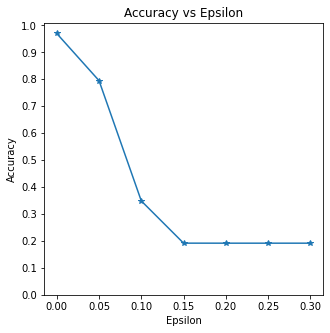

In [14]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

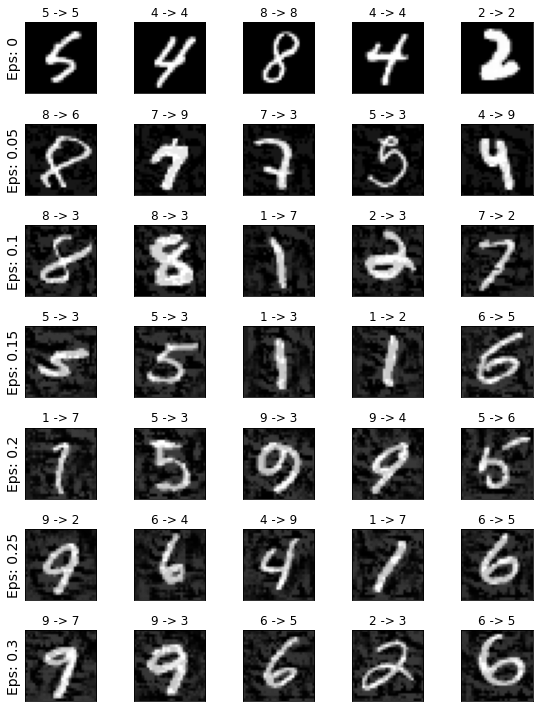

In [15]:
count = 0
plt.figure(figsize=(8,10))

for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        count += 1
        plt.subplot(len(epsilons),len(examples[0]),count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [ ]:
 orig,adv,ex  = examples[5][1]

In [ ]:
plt.imshow(ex)